In [1]:
%pylab inline

from __future__ import print_function
import numpy as np
import theano
import theano.tensor as T
import time
import datetime
import os

import lasagne
from copy import deepcopy

import SimpleITK as sitk
import random
from skimage import exposure
from skimage.morphology import binary_closing

import sklearn.cross_validation

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5004)


In [2]:
def extract_patches(mri, label, half_patch_size=5, negative_boost_size=2.0):
    
    assert mri.shape == label.shape
    
    z_size, x_size, y_size = mri.shape
    positive_patches = []
    negative_patches = []

    for z in xrange(half_patch_size, z_size-half_patch_size):
        if label[z,:,:].sum() > 1000: continue # workaround to remove white slices into the label dataset
        for x in xrange(half_patch_size, x_size-half_patch_size):
            for y in xrange(half_patch_size, y_size-half_patch_size):
                if label[z,x,y] == 1:
                    positive_patches.append(mri[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1])
                elif label[z,x,y] == 0:
                    negative_patches.append(mri[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1])
    
    random.shuffle(negative_patches)
    number_of_negative_cases = int(len(positive_patches) + (len(positive_patches)*negative_boost_size))
    selected_negative_patches = deepcopy(negative_patches[:number_of_negative_cases])
    del(negative_patches)
    
    return (positive_patches, selected_negative_patches)

In [3]:
def patchimg2differentview(patch):
    
    z_size, x_size, y_size = patch.shape
    
    X = np.zeros((z_size * 3, x_size, y_size), dtype=np.float32)
    
    counter = 0
    for z in xrange(z_size):
        X[counter,:,:] = patch[z,:,:]
        counter += 1
    for x in xrange(x_size):
        X[counter,:,:] = patch[:,x,:]
        counter += 1
    for y in xrange(y_size):
        X[counter,:,:] = patch[:,:,y]
        counter += 1
    
    return X.astype(np.float32)

In [4]:
def patches2CNNformat(patches, label, half_patch_size=5):
    
    X = np.zeros((len(patches), 3 * ((2 * half_patch_size)+1), (half_patch_size*2)+1, (half_patch_size*2)+1), dtype=np.float32)
    y = np.zeros((len(patches)), dtype=np.int32) * -1
    
    for i, patch in enumerate(patches):
        X[i,:,:,:] = patchimg2differentview(patch)
        y[i] = label
    
    assert -1 not in y
    
    return X.astype(np.float32), y.astype(np.int32)

In [5]:
def get_resized_img(img_fn, data_type = sitk.sitkFloat32):
    
    img = sitk.ReadImage(img_fn)
    size = img.GetSize()
    ratio = [1.0/i for i in img.GetSpacing()]
    new_size = [int(size[i]/ratio[i]) for i in range(3)]
    
    rimage = sitk.Image(new_size, data_type)
    rimage.SetSpacing((1,1,1))
    rimage.SetOrigin(img.GetOrigin())
    tx = sitk.Transform()
    
    interp = sitk.sitkLinear
    if data_type == sitk.sitkInt16:
        interp = sitk.sitkNearestNeighbor
    
    new_image = sitk.Resample(img, rimage, tx, interp, data_type)
    
    return sitk.GetArrayFromImage(new_image)

In [6]:
def needles2tips(only_needles, image_array, number_of_slices=2):
    needles_masks_array = np.zeros_like(image_array).astype(float)  
    for file_item in only_needles:
        this_mask = file_item.astype(np.float)
        if np.sum(this_mask) < (np.shape(this_mask)[0] * np.shape(this_mask)[1] * np.shape(this_mask)[2]):
            this_mask = binary_closing(this_mask,selem=np.ones((3,3,3)))
            found=False
            row = 0#np.shape(this_mask)[0]-1
            while found==False and row < np.shape(this_mask)[0]-1 :
                #print(row)
                this_row = this_mask[row,:,:]
                if np.sum(this_row) > 0:
                    #print(row)
                    found = True
                    temp = np.add(needles_masks_array[row:row+1+number_of_slices,:,:],this_mask[row:row+1+number_of_slices,:,:])
                    temp[temp!=0] = 1
                    needles_masks_array[row:row+1+number_of_slices,:,:] = temp 
                row += 1
    return needles_masks_array.astype(np.int32)

In [7]:
def pad_volume(img, half_patch_size=5):
    npad = ((half_patch_size,half_patch_size),(half_patch_size,half_patch_size),(half_patch_size,half_patch_size))
    return np.lib.pad(img, npad, "constant", constant_values=0)

In [8]:
def data_for_CNN(general_folder, half_patch_size=5):
    folders_cases = os.listdir(general_folder)
    
    X = np.ones((1, 3 * ((2 * half_patch_size)+1), (half_patch_size*2)+1, (half_patch_size*2)+1), dtype=np.float32) * -1.0
    y = np.ones((1), dtype=np.int32) * -1.0
    
    for folder_case in folders_cases:
        print("Patient #%s" % (folder_case))
        full_case_path = general_folder + os.sep + folder_case
        
        volumetric_files = os.listdir(full_case_path)
        
        assert "case.nrrd" in volumetric_files
        del(volumetric_files[volumetric_files.index("case.nrrd")])
        
        mri = get_resized_img(full_case_path + os.sep + "case.nrrd")
        unpad_mri = deepcopy(mri)
        #print("MRI min %f -- max %f" % (mri.min(), mri.max()))
        mri = pad_volume(mri, half_patch_size=half_patch_size)
        
        needles = []
        for volumetric_file in volumetric_files:
            label = get_resized_img(full_case_path + os.sep + volumetric_file, sitk.sitkInt16)
            label[label!=0]=1
            #if 1 in label: print("1!")
            needles.append(label)
        
        tips = needles2tips(needles, unpad_mri)
        #print("Tips min %f -- max %f" % (tips.min(), tips.max()))
        tips = pad_volume(tips, half_patch_size=half_patch_size)
        #tips[tips!=0]=1
        #tips = tips.astype(np.int32)
        positive_patches, negative_patches = extract_patches(mri, tips, half_patch_size=half_patch_size)
        if len(positive_patches) > 0:
            print(" %d positive patches and %d negative patches" % (len(positive_patches), len(negative_patches)))
            X_temp_pos, y_temp_pos = patches2CNNformat(positive_patches, 1, half_patch_size=half_patch_size)
            X_temp_neg, y_temp_neg = patches2CNNformat(negative_patches, 0, half_patch_size=half_patch_size)
            
            X = np.concatenate((X, X_temp_pos), axis=0)
            y = np.concatenate((y, y_temp_pos), axis=0)
            X = np.concatenate((X, X_temp_neg), axis=0)
            y = np.concatenate((y, y_temp_neg), axis=0)
    
    assert -1 in X[0,:,:,:] and y[0] == -1
    X = X[1:,:,:,:].astype(np.float32)
    y = y[1:].astype(np.int32)
    
    return X, y

In [9]:
half_patch_size = 5

In [10]:
X, y = data_for_CNN("../LabelMaps", half_patch_size=half_patch_size)
#saved_data = np.load('../patches_jun27_halfpatchsize5odd.npz')
#X, y = saved_data['arr_0'], saved_data['arr_1']

Patient #77
Patient #69
 54 positive patches and 162 negative patches
Patient #51
 137 positive patches and 411 negative patches
Patient #44
 285 positive patches and 855 negative patches
Patient #76
 919 positive patches and 2757 negative patches
Patient #28
 66 positive patches and 198 negative patches
Patient #56
 66 positive patches and 198 negative patches
Patient #74
Patient #48
Patient #59
 226 positive patches and 678 negative patches
Patient #40
 56 positive patches and 168 negative patches
Patient #39
 24 positive patches and 72 negative patches
Patient #33
 10 positive patches and 30 negative patches
Patient #50
 10 positive patches and 30 negative patches
Patient #49
 33 positive patches and 99 negative patches
Patient #25
Patient #30
Patient #75
 6 positive patches and 18 negative patches
Patient #63
 87 positive patches and 261 negative patches
Patient #14
 143 positive patches and 429 negative patches
Patient #71
 72 positive patches and 216 negative patches
Patient #22


In [11]:
#np.savez('../patches_jun27_halfpatchsize5odd.npz', X, y)

In [12]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.20)
X_test, X_val, y_test, y_val = sklearn.cross_validation.train_test_split(X_test, y_test, test_size=0.33)

In [13]:
m, s = X_train.mean(), X_train.std()

X_train -= m
X_train /= s

X_val -= m
X_val /= s

X_test -= m
X_test /= s

In [14]:
X_train.shape, X_test.shape, X_val.shape

((17088, 33, 11, 11), (2862, 33, 11, 11), (1410, 33, 11, 11))

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [16]:
def build_cnn(single_entry_shape, input_var=None):
    
    network = lasagne.layers.InputLayer(shape=(None, single_entry_shape[0], single_entry_shape[1], 
                                               single_entry_shape[2]),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=480, filter_size=(3, 3),  #120
            nonlinearity=lasagne.nonlinearities.leaky_rectify,
            W=lasagne.init.HeNormal())
    #network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=240, filter_size=(2, 2), #120
            nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
           lasagne.layers.dropout(network, p=.5),
            num_units=120, #120*2*2
           nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
           lasagne.layers.dropout(network, p=.5),
            num_units=60,
           nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [17]:
num_epochs = 550
batchsize = 32
single_entry_shape = X_train.shape[1:]

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

network = build_cnn(single_entry_shape, input_var)

In [18]:
# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var) # multiclass_hinge_loss
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.001, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                    dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    
    now = datetime.datetime.now()
    print("Epoch %d started on %s" % (epoch + 1, now.strftime("%Y-%m-%d %H:%M")))
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchsize, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, batchsize, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Starting training...
Epoch 1 started on 2016-06-28 01:25
Epoch 1 of 550 took 5.030s
  training loss:		0.482397
  validation loss:		0.377931
  validation accuracy:		84.02 %
Epoch 2 started on 2016-06-28 01:25
Epoch 2 of 550 took 5.031s
  training loss:		0.355593
  validation loss:		0.315053
  validation accuracy:		86.58 %
Epoch 3 started on 2016-06-28 01:25
Epoch 3 of 550 took 5.027s
  training loss:		0.310192
  validation loss:		0.276768
  validation accuracy:		87.29 %
Epoch 4 started on 2016-06-28 01:25
Epoch 4 of 550 took 5.026s
  training loss:		0.277965
  validation loss:		0.248422
  validation accuracy:		88.85 %
Epoch 5 started on 2016-06-28 01:25
Epoch 5 of 550 took 5.025s
  training loss:		0.249823
  validation loss:		0.219539
  validation accuracy:		89.20 %
Epoch 6 started on 2016-06-28 01:25
Epoch 6 of 550 took 5.028s
  training loss:		0.223811
  validation loss:		0.244884
  validation accuracy:		89.42 %
Epoch 7 started on 2016-06-28 01:25
Epoch 7 of 550 took 5.025s
  training

In [19]:
# SAVE NETWORK
#np.savez('../model_needle_june27_HALFPATCHSIZE5odd.npz', *lasagne.layers.get_all_param_values(network))

In [20]:
# LOAD NETWORK
"""
with np.load('../model_needle_june24.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)
"""

"\nwith np.load('../model_needle_june24.npz') as f:\n    param_values = [f['arr_%d' % i] for i in range(len(f.files))]\nlasagne.layers.set_all_param_values(network, param_values)\n"

In [21]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
predict_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))
predict_confidence = theano.function([input_var], test_prediction)

In [22]:
ind = 17
a = X_test[ind,:,:,:].reshape((1,3*((2*half_patch_size)+1),(2*half_patch_size)+1,(2*half_patch_size)+1))
predict_label_patch = predict_fn(a)[0]

print(predict_label_patch, y_test[ind])

0 0


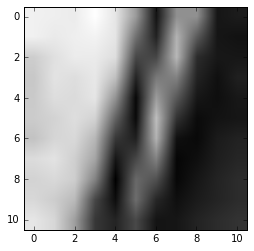

In [23]:
imshow(a[0,5,:,:], cmap='gray')

In [24]:
#test_pat_sitk = sitk.ReadImage('LabelMaps/64/case.nrrd')
test_pat = get_resized_img('../LabelMaps/64/case.nrrd')
test_pat = test_pat[140:,15:180,80:230]
test_pat = pad_volume(test_pat, half_patch_size=half_patch_size)

pat_sitk = sitk.GetImageFromArray(test_pat.astype(np.float32))
sitk.WriteImage(pat_sitk, '../test_pat.nrrd')

final_label = np.zeros_like(test_pat)
test_pat.shape

(62, 175, 160)

In [25]:
z_size, x_size, y_size = test_pat.shape

for z in xrange(half_patch_size, z_size-half_patch_size):
    print(z)
    for x in xrange(half_patch_size, x_size-half_patch_size):
        for y in xrange(half_patch_size, y_size-half_patch_size):
            patient_patch_img = test_pat[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1]
            patient_patch = patchimg2differentview(patient_patch_img).reshape((1,3*((2*half_patch_size)+1),(2*half_patch_size)+1,(2*half_patch_size)+1)).astype(np.float32)
            patient_patch -= m
            patient_patch /= s
            predicted_label = int(predict_fn(patient_patch)[0])
            
            final_label[z,x,y] = predicted_label

final_label_sitk = sitk.GetImageFromArray(final_label)
sitk.WriteImage(final_label_sitk, '../test_label.nrrd')

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [26]:
print("Done!")

Done!
